# Load modules

In [1]:
import numpy as np
import pandas as pd
from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation
from pipedream_solver.nutils import interpolate_sample

import matplotlib.pyplot as plt
import seaborn as sns

import influxdb 
import pandas as pd
from dateutil import tz

# import the libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%matplotlib inline

import pandas as pd
import numpy as np
from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation
import ast
import pandas as pd
import seaborn as sns
sns.set_palette('husl')


import time
import schedule

from datetime import datetime, timedelta
from influxdb import InfluxDBClient
from pytz import timezone


# Load pipedream model information 

In [2]:
superjunctions = pd.read_csv('../data/waller_superjunctions.csv', index_col=0)  
superlinks = pd.read_csv('../data/waller_creek_superlinks.csv', index_col=0) 
subbasins = pd.read_excel('../data/Waller_HMS_model_data.xlsx', sheet_name=0)

# Specify simulation parameters

# Unit conversions
m_per_ft = 0.3048
ft_per_mi = 5280.
in_per_ft = 12.
s_per_min = 60
ns_per_s = 1e9

# Manual edits to model
superlinks.loc[21, ['g2', 'g3']] = 0., 7.777146367746631
superlinks['C_uk'] = 0.
superlinks['C_dk'] = 0.

# Manual edits to hydrology params
lag_time_adjust_ratio = 0.4
CN_adjust_ratio = 1.0

# Simulation params
sample_interval = 30
node_ids = ['Bridge1','Bridge2','Bridge3','Bridge4','Bridge5']
site_junction_name = 'J_WLR18_COMB_HEMP'
site_link_name = 'R_WLR16'
site_junction_index = 14
site_link_index = 21

# Define runoff functions

In [3]:
from hydrology import scs_composite_CN, scs_excess_precipitation, scs_uh_runoff, precip_data, scs_excess_precipitation

# Load LCRA flow, depth, and precipitation data

In [4]:
# Add LCRA data (Flow, depth, and precipitation data for the 'Waller Creek at 23rd Street' gage from the LCRA site.)
LCRA_2022 = pd.read_excel('../data/LCRA_Export/LCRA_Export_2022.xlsx')
LCRA_2023 = pd.read_excel('../data/LCRA_Export/LCRA_Export_2023.xlsx')
LCRA=pd.concat([LCRA_2022[8:],LCRA_2023[8:]])
LCRA = LCRA.set_index('Site Name')
LCRA.index.name = 'Time'
# Handle timezone
LCRA = LCRA.tz_localize('US/Central', nonexistent='shift_forward').tz_convert('UTC')
# Rename columns to be more descriptive
LCRA = LCRA.rename(columns={'W3A' : 'depth__ft', 'W3A.1' : 'flow_rate__cfs', 'W3A.3' : 'precip_tot__in'})
LCRA = LCRA.drop('W3A.2', axis=1)
# Filter dataset to time period


# Load ultrasonic sensor data

In [5]:
# Visualizing the actual depth of Waller Creeks  

# set up the lists(node_id and length between node and bottom)
node_id_list=['Bridge1','Bridge2','Bridge3','Bridge4','Bridge5']
length_ntb_list =[3911.6, 3175, 4927.6, 4978.4, 3556]
ntb_df=pd.DataFrame(length_ntb_list, columns=['depth'])
ntb_df=ntb_df.set_index([node_id_list])

#set up the influxDBClient 
client_dict = {'host' : 'ec2-3-91-156-8.compute-1.amazonaws.com',
               'port' : 8086,
               'username' : 'generic_node',
               'password' : 'GlareShellTwilight',
               'database' : 'RAW'}

In [ ]:
def scs_excess_precipitation(precip__in, CN,P_now, decay_function=lambda x: 0.):
    # Set up SCS parameters
    P = precip__in.values
    S = 1000 / CN -10 #potential maximum abstraction

    
    # Compute cumulative excess precipitation
    Pes = []
    Pes_inc = []
    Pe_prev = 0.
    P_now = P_now
    n = len(P)
    
    for t in range(n):
        Ia = 0.2 * S #inital abstraction
        Pt = P[t] #precipitaton at time t
     
        P_now = Pt + P_now  #accumulated precipitation
        loss = decay_function(P_now)
        if P_now - loss <= 0.:
            loss = 0.
        P_now = P_now - loss  ## I used this code for scs continous but still not fit well.
        
        if P_now <= Ia:
            Pe = 0.
        else:        
            Pe = (P_now - 0.2 * S)**2 / (P_now + 0.8 * S) #excess precipitation
        
        Pe_inc = Pe - Pe_prev + loss
        Pes.append(Pe)
        Pes_inc.append(Pe_inc)
        Pe_prev = Pe
        

    # Assign time index to excess precipitation output
    excess_precip_cum__in = pd.Series(Pes, index=precip__in.index)
    excess_precip__in = pd.Series(Pes_inc, index=precip__in.index)
    return excess_precip_cum__in, excess_precip__in, P_now 

# Compute runoff into each superjunction

In [116]:
# Compute runoff into each superjunction
def Model_initialization(precip__in,subbasins,P_now,decay_function=lambda x: 0.):
    keepGoing=True
    while keepGoing:
        try:
            Q_in = {}
            CNs = []
            # Manual edits to hydrology params
            lag_time_adjust_ratio = 1.0
            CN_adjust_ratio = 1.0


            # For each subbasin...
            for i in range(len(subbasins)):
                
                # Load subbasin parameters
                CN_C = subbasins['Curve Number'][i]
                A_Imp = subbasins['Impervious Percent'][i]
                area__sq_mi = subbasins['Area (mi2)'][i]
                downstream = subbasins['Downstream'][i]
                lag_time__min = subbasins['Lag Time'][i] * lag_time_adjust_ratio

                # Compute composite curve number
                CN = scs_composite_CN(CN_C, A_Imp) * CN_adjust_ratio
                CN = min(CN, 98)

                # Compute excess precipitation
                excess_precip_cum__in, excess_precip__in, P_now = scs_excess_precipitation(precip__in, CN,P_now,decay_function=decay_function)

                # Compute runoff using unit hydrograph
                runoff__cms = scs_uh_runoff(excess_precip__in, uh__dimless, area__sq_mi, sample_interval,lag_time__min)
                Q_in[downstream] = runoff__cms

            # Format flow input as DataFrame
            Q_in = pd.DataFrame.from_dict(Q_in)
            # Add flow input for missing sites
            Q_in['UPSTREAM_WALLER'] = Q_in['R_WLR01']
            Q_in['UPSTREAM_HEMPHILL'] = Q_in['R_HEM01']
            Q_in[[name for name in superjunctions['name'] if not name in Q_in.columns]] = 0.
            # Ensure flow input is only for superjunctions specified in table
            Q_in = Q_in[superjunctions['name'].tolist()]
            # Remove NaN values
            Q_in = Q_in.fillna(0.)
            # Copy flow input with original timestamps
            Q_in_orig = Q_in.copy()
            # Convert flow input index to integer index starting with zero
            Q_in.index = Q_in.index.astype(int) / 1e9
            Q_in.index -= Q_in.index.min()
            keepGoing=False
        
        except ValueError:
            keepGoing=True
        except KeyError :
            keepGoing=True
        except AssertionError:
            keepGoing=True


    return excess_precip__in,Q_in,P_now

In [31]:
# Run simulation without KF
def Model_simulation(excess_precip__in,Q_in,dt,superlinks,superjunctions,load_data,measurements):
    keepGoing=True
    while keepGoing:
        try:


            superlink = SuperLink(superlinks, superjunctions,internal_links=30, mobile_elements=True)
            

            H_j = []
            h_Ik = []
            Q_uk = []
            Q_dk = []

            # Set constant timestep (in seconds)

            # Add constant baseflow
            baseflow = 0.35e-3  * np.ones(superlink._h_Ik.size)

            # Create simulation context manager
            with Simulation(superlink, Q_in=Q_in, Qcov=Qcov, Rcov=Rcov,
                C=C_kal, H=H_kal, interpolation_method='nearest') as simulation:
                simulation.model.load_state(load_data)
                # While simulation time has not expired...
                while simulation.t <= simulation.t_end:
                    # Step model forward in time
                    simulation.step(dt=dt, num_iter=8, Q_Ik=baseflow)
                    # Get measured value
                    next_measurement = interpolate_sample(simulation.t,
                                                          measurements.index.values,
                                                          measurements.values)
                    # Apply Kalman filter with measured value
                    simulation.kalman_filter(next_measurement, dt=dt)
                    simulation.model.reposition_junctions()
                    # Print progress bar
                    simulation.print_progress()
                    # Save states
                    H_j.append(simulation.model.H_j.copy())
                    h_Ik.append(simulation.model.h_Ik.copy())
                    Q_uk.append(simulation.model.Q_uk.copy())
                    Q_dk.append(simulation.model.Q_dk.copy())

            time_index = pd.date_range(start=excess_precip__in.index.min(), 
                                       periods=len(H_j), 
                                       freq=f'{dt}s')

            # Convert saved states to dataframes
            H_j = pd.DataFrame(np.vstack(H_j), index=time_index, columns=superjunctions['name'])
            h_Ik = pd.DataFrame(np.vstack(h_Ik), index=time_index)
            Q_uk = pd.DataFrame(np.vstack(Q_uk), index=time_index, columns=superlinks['name'])
            Q_dk = pd.DataFrame(np.vstack(Q_dk), index=time_index, columns=superlinks['name'])

            # Compute depth
            h_j = H_j - simulation.model._z_inv_j
            final_data=simulation.model.states
            
            keepGoing=False
        
        except ValueError:
            keepGoing=True
        except KeyError :
            keepGoing=True
        except AssertionError:
            keepGoing=True

    
    return H_j,h_Ik,Q_uk,Q_dk,h_j,final_data

In [149]:
def Model_simulation(excess_precip__in,Q_in,dt,superlinks,superjunctions,load_data):
    load_data=load_data
    keepGoing=True
    while keepGoing:
        try:


            superlink = SuperLink(superlinks, superjunctions,internal_links=30, mobile_elements=True)
            

            H_j = []
            h_Ik = []
            Q_uk = []
            Q_dk = []
            S1=[]
            S2=[]
            S3=[]
            S4=[]

            # Set constant timestep (in seconds)

            # Add constant baseflow
            baseflow = 0.35e-3 * np.ones(superlink._h_Ik.size)

            # Create simulation context manager
            with Simulation(superlink, Q_in=Q_in) as simulation:
                print(load_data)
                simulation.model.load_state(load_data)
                # While simulation time has not expired...
                print(simulation.t,simulation.t_end)
                
                while simulation.t <= simulation.t_end:
                    # Step model forward in time
                    simulation.step(dt=dt, num_iter=8, Q_Ik=baseflow)
                    simulation.model.reposition_junctions()
                    # Print progress bar
                    simulation.print_progress()
                    # Save states
                    H_j.append(simulation.model.H_j.copy())
                    h_Ik.append(simulation.model.h_Ik.copy())
                    Q_uk.append(simulation.model.Q_uk.copy())
                    Q_dk.append(simulation.model.Q_dk.copy())
                    S1.append(simulation.model.h_Ik[simulation.model._kI == 20][27].copy())
                    S2.append(simulation.model.h_Ik[simulation.model._kI == 21][15].copy())
                    S3.append(simulation.model.h_Ik[simulation.model._kI == 22][1].copy())
                    S4.append(simulation.model.h_Ik[simulation.model._kI == 22][15].copy())

            time_index = pd.date_range(start=excess_precip__in.index.min(), 
                                       periods=len(H_j), 
                                       freq=f'{dt}s')

            # Convert saved states to dataframes
            H_j = pd.DataFrame(np.vstack(H_j), index=time_index, columns=superjunctions['name'])
            h_Ik = pd.DataFrame(np.vstack(h_Ik), index=time_index)
            Q_uk = pd.DataFrame(np.vstack(Q_uk), index=time_index, columns=superlinks['name'])
            Q_dk = pd.DataFrame(np.vstack(Q_dk), index=time_index, columns=superlinks['name'])
            S1=pd.DataFrame(np.vstack(S1), index=time_index)
            S2=pd.DataFrame(np.vstack(S2), index=time_index)
            S3=pd.DataFrame(np.vstack(S3), index=time_index)
            S4=pd.DataFrame(np.vstack(S4), index=time_index)

            # Compute depth
            h_j = H_j - simulation.model._z_inv_j
            final_data=simulation.model.states
            
            
            keepGoing=False
        
        except ValueError:
            keepGoing=True
        except KeyError :
            keepGoing=True
        except AssertionError:
            keepGoing=True

    
    return H_j,h_Ik,Q_uk,Q_dk,h_j,final_data,S1,S2,S3,S4


# Automatic figure graph

# Simulation 

In [9]:


## Load pipedream model information 
superjunctions = pd.read_csv('../data/waller_superjunctions.csv', index_col=0)  
superlinks = pd.read_csv('../data/waller_creek_superlinks.csv', index_col=0) 
subbasins = pd.read_csv('../data/Waller_HMS_model_data.csv', index_col=0)

superjunctions

,name,id,z_inv,h_0,bc,storage,a,b,c,max_depth
0,J_WLR01_RR_S_OF_MORROW,0,220.133601,0.00001,False,functional,0.0,0.0,100.0,inf
1,J_WLR02_LAMAR,1,215.563704,0.00001,False,functional,0.0,0.0,100.0,inf
2,J_WLR03_TRIB_AT_SWANEE,2,211.506633,0.00001,False,functional,0.0,0.0,100.0,inf
3,J_WLR05_COMB_AT_HUNTLAND,3,205.822296,0.00001,False,functional,0.0,0.0,100.0,inf
4,J_WLR06_US_POND_REILLY,4,200.366376,0.00001,False,functional,0.0,0.0,100.0,inf
5,J_WLR07_KOENIG,5,196.397880,0.00001,False,functional,0.0,0.0,100.0,inf
6,J_WLR08_NORTH_LOOP,6,192.618360,0.00001,False,functional,0.0,0.0,100.0,inf
7,J_WLR09_51ST,7,190.853568,0.00001,False,functional,0.0,0.0,100.0,inf
8,J_WLR10_INTRAMURAL_FIELDS,8,186.827160,0.00001,False,functional,0.0,0.0,100.0,inf
9,J_WLR12_COMB_AT_DUVAL,9,180.024024,0.00001,False,functional,0.0,0.0,100.0,inf


In [10]:

# Specify simulation parameters
# Unit conversions
m_per_ft = 0.3048
ft_per_mi = 5280.
in_per_ft = 12.
s_per_min = 60
ns_per_s = 1e9

# Manual edits to model
#superlinks.loc[21, ['g2', 'g3']] = 0., 7.777146367746631
#superlinks['C_uk'] = 0.
#superlinks['C_dk'] = 0.

# Manual edits to model
superlinks.loc[20, ['g2', 'g3']] = 5.6, 6.3
superlinks.loc[21, ['g2', 'g3']] = 3.7, 3.977146367746631
superlinks.loc[22, ['g2', 'g3']] = 0., 7.777146367746631
superlinks.loc[23, ['g2', 'g3']] = 0., 8.3714367746631
superlinks['C_uk'] = 0.
superlinks['C_dk'] = 0.
superjunctions.loc[16, ['z_inv']]=147.9

# Simulation params
sample_interval = 30

site_junction_name = 'J_WLR18_COMB_HEMP'
site_link_name = 'R_WLR16'
site_junction_index = 14
site_link_index = 21

# Load unit hydrograph
# Load dimensionless unit hydrograph
uh__dimless = pd.read_csv('../data/unit_hydrograph.csv')
# Drop unnecessary columns and rows
uh__dimless = uh__dimless[['time ratios', 'discharge ratios']].dropna()
dt = 10

In [11]:
# Set up Kalman filtering parameters
n = len(superjunctions)
p = n
m = 4

process_std_dev = 1e-2
measurement_std_dev = 2e-4

H_kal = np.zeros((m, n))
H_kal[0, 13] = 1.
H_kal[1, 14] = 1.
H_kal[2, 15] = 1.
H_kal[3, 16] = 1.
Qcov = (process_std_dev**2)*np.eye(p)
Rcov = (measurement_std_dev**2)*np.eye(m)

C_kal = np.zeros((n, p))
C_kal[np.arange(n), np.arange(p)] = 1.

In [12]:
bridge_2 = pd.read_csv('../data/bridge2_20220627-20230520.csv', index_col=0)
bridge_2.index = pd.to_datetime(bridge_2.index)
bridge_3 = pd.read_csv('../data/bridge3_20220627-20230520.csv', index_col=0)
bridge_3.index = pd.to_datetime(bridge_3.index)
bridge_4 = pd.read_csv('../data/bridge4_20220627-20230520.csv', index_col=0)
bridge_4.index = pd.to_datetime(bridge_4.index)
bridge_5 = pd.read_csv('../data/bridge5_20220627-20230520.csv', index_col=0)
bridge_5.index = pd.to_datetime(bridge_5.index)

In [195]:
bridge_2 = pd.read_csv('../20230612/bridge2_classification.csv', index_col=0)
bridge_2.index = pd.to_datetime(bridge_2.index)
bridge_3 = pd.read_csv('../20230612/bridge3_classification.csv', index_col=0)
bridge_3.index = pd.to_datetime(bridge_3.index)
bridge_4 = pd.read_csv('../20230612/bridge4_classification.csv', index_col=0)
bridge_4.index = pd.to_datetime(bridge_4.index)
bridge_5 = pd.read_csv('../20230612/bridge5_classification.csv', index_col=0)
bridge_5.index = pd.to_datetime(bridge_5.index)

In [121]:
#set client and inital parameter
client = InfluxDBClient(host='ec2-13-58-107-29.us-east-2.compute.amazonaws.com',username='ewre_student',password='happylife!',database='tomorrow_api' )

def recall_forecast_rainIntensity():
    #match the timezone
    
  #  current_time = datetime.now()
  #  central = timezone('US/Central')
  #  published_gmt = current_time.replace(tzinfo=central)
  #  published_gmt_plus1h=published_gmt+timedelta(hours = 1)
  #  published_gmt_minus1h=published_gmt-timedelta(hours = 1)

    #set time scale (now : now+1h)
  #  now=published_gmt.strftime("%Y-%m-%dT%H:%M:%SZ")
  #  now_plus1=published_gmt_plus1h.strftime("%Y-%m-%dT%H:%M:%SZ")
  #  now_minus1=published_gmt_minus1h.strftime("%Y-%m-%dT%H:%M:%SZ")




    
    start=datetime(2023, 5, 13, 4, 55, 0)
    end=datetime(2023, 5, 19,19, 0, 0)
    utc = timezone('UTC')
    central = timezone('US/Central')
    start_gmt = start.replace(tzinfo=central)
    end_gmt = end.replace(tzinfo=central)

    start_cst = start_gmt.astimezone(utc)
    end_cst = end_gmt.astimezone(utc)
   
    #set time scale (now : now+1h)
    start_time=start_cst.strftime("%Y-%m-%dT%H:%M:%SZ")
    end_time=end_cst.strftime("%Y-%m-%dT%H:%M:%SZ")
   

    # collect precipiation probability
    #now_result=client.query("SELECT rainIntensity FROM weather_forecast WHERE location ='30.2871667, -97.7341111' AND time >= '"+now+"' AND time <= '"+now_plus1+"'")
    now_result=client.query("SELECT rainIntensity FROM weather_forecast WHERE location ='30.2871667, -97.7341111' AND time >= '"+start_time+"' AND time <= '"+end_time+"'")
   
    return now_result


In [197]:

codisp = {}
# Create array for detected outliers
is_outlier = []
is_outliers = []
# Create a dict to store anomaly score of each point
avg_codisp = {}

#start_date='20220701'
#end_date='20220801'

start_date='20230509'
end_date='20230513 10:50:00'

#end_date='20230520'

final_data={}
file_name='startDate'+str(start_date)+'_endDate'+str(end_date)
print(file_name)

P_now = 0.

precip__in_realtime=precip_data(LCRA, start_date, end_date)
dt=10
now_result=recall_forecast_rainIntensity()

forecast_precip=np.array([],dtype='f')
forecast_time=np.array([],dtype='str')
for reading in now_result:
    for data in reading:
        forecast_precip=np.append (forecast_precip,data['rainIntensity']/60)
        forecast_time=np.append (forecast_time,data['time'])

print(len(forecast_precip))
forecast_time=pd.to_datetime(forecast_time)
forecast_precip=pd.DataFrame(forecast_precip, index=forecast_time,columns=['precip_tot__in'])

print('forecast_precip')
forecast_precip['dt__s'] = np.roll(pd.Series(forecast_precip.index).diff(1).dt.seconds.values, -1)
# Compute precipitation rate from total inches and dt
forecast_precip['precip_rate__in_per_s'] = forecast_precip['precip_tot__in'] / forecast_precip['dt__s']
# Compute inches of precipitation for desired sample interval
precip__in_avg = sample_interval * forecast_precip['precip_rate__in_per_s'].resample(f'{sample_interval}s').mean().interpolate()
precip__in_forecast=precip__in_avg
precip__in=precip__in_realtime




startDate20230509_endDate20230513 10:50:00
9486
forecast_precip


In [196]:
start_date='20230513 10:51:00'
end_date='20230519'

#end_date='20230520'

final_data={}
file_name='startDate'+str(start_date)+'_endDate'+str(end_date)
print(file_name)

P_now = 0.

precip__in_realtime=precip_data(LCRA, start_date, end_date)
dt=10
now_result=recall_forecast_rainIntensity()

forecast_precip=np.array([],dtype='f')
forecast_time=np.array([],dtype='str')
for reading in now_result:
    for data in reading:
        forecast_precip=np.append (forecast_precip,data['rainIntensity']/60)
        forecast_time=np.append (forecast_time,data['time'])

print(len(forecast_precip))
forecast_time=pd.to_datetime(forecast_time)
forecast_precip=pd.DataFrame(forecast_precip, index=forecast_time,columns=['precip_tot__in'])

print('forecast_precip')
forecast_precip['dt__s'] = np.roll(pd.Series(forecast_precip.index).diff(1).dt.seconds.values, -1)
# Compute precipitation rate from total inches and dt
forecast_precip['precip_rate__in_per_s'] = forecast_precip['precip_tot__in'] / forecast_precip['dt__s']
# Compute inches of precipitation for desired sample interval
precip__in_avg = sample_interval * forecast_precip['precip_rate__in_per_s'].resample(f'{sample_interval}s').mean().interpolate()
precip__in_forecast=precip__in_avg
precip__in_2=precip__in_realtime


startDate20230513 10:51:00_endDate20230519


/Users/future_water_system/20230612/hydrology.py:48: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  LCRA = LCRA.loc[start_date:end_date]


9486
forecast_precip


In [198]:
bridge_2=bridge_2[start_date:end_date]
bridge_3=bridge_3[start_date:end_date]
bridge_4=bridge_4[start_date:end_date]
bridge_5=bridge_5[start_date:end_date]


In [199]:

if precip__in.empty != True:
    
    #excess_precip__in,Q_in,P_now=Model_initialization(precip__in,subbasins,P_now,decay_function=lambda x: (1 - 0.99675)*x)
    excess_precip__in,Q_in,P_now=Model_initialization(precip__in,subbasins,P_now,decay_function=lambda x: (1 - 0.9971)*x)

    measurements = pd.concat([bridge_2.resample('5min').mean().interpolate(method='nearest'),
                          bridge_3.resample('5min').mean().interpolate(method='nearest'),
                          bridge_4.resample('5min').mean().interpolate(method='nearest'),
                          bridge_5.resample('5min').mean().interpolate(method='nearest')], axis=1).interpolate()
    measurements = measurements.fillna(method='backfill')

    bridge_2=(bridge_2.iloc[bridge_2.index.get_indexer(measurements.index, method='nearest')]
                     .set_index(measurements.index))

    bridge_3=(bridge_3.iloc[bridge_3.index.get_indexer(measurements.index, method='nearest')]
                     .set_index(measurements.index))

    bridge_4=(bridge_4.iloc[bridge_4.index.get_indexer(measurements.index, method='nearest')]
                     .set_index(measurements.index))

    bridge_5=(bridge_5.iloc[bridge_5.index.get_indexer(measurements.index, method='nearest')]
                     .set_index(measurements.index))

    interpolated_bridge_data = pd.concat([bridge_2,
                              bridge_5,
                              bridge_3,
                              bridge_4
                              ], axis=1).interpolate()

    measurements=interpolated_bridge_data[['Bridge2', 'Bridge5', 'Bridge3', 'Bridge4']]
    labels=interpolated_bridge_data[['class']]

    measurements = measurements + superjunctions.loc[[13, 14, 15, 16], 'z_inv'].values
    measurements.index = measurements.index - precip__in.index.min()
    measurements.index = measurements.index.astype(int) / 1e9    

    superlink = SuperLink(superlinks, superjunctions,internal_links=30, mobile_elements=True)


    H_j = []
    h_Ik = []
    Q_uk = []
    Q_dk = []
    residuals = []
    scores = []

    # Set constant timestep (in seconds)

    # Add constant baseflow
    baseflow = 0.35e-3  * np.ones(superlink._h_Ik.size)

    # Create simulation context manager
    with Simulation(superlink, Q_in=Q_in, Qcov=Qcov, Rcov=Rcov,
                C=C_kal, H=H_kal, interpolation_method='nearest') as simulation:
        simulation.model.load_state(final_data)
        # While simulation time has not expired...
        while simulation.t <= simulation.t_end:
            # Step model forward in time
            simulation.step(dt=dt, num_iter=8, Q_Ik=baseflow)
            # Get measured value
            next_measurement = interpolate_sample(simulation.t,
                                                  measurements.index.values,
                                                  measurements.values,
                                                  method=0)
            # Apply Kalman filter with measured value
            H = H_kal
            C = C_kal
            Z_next = next_measurement
            P_x_k_k = simulation.P_x_k_k
            A_1, A_2, b = simulation.model._semi_implicit_system(_dt=dt)
            I = np.eye(A_1.shape[0])
            y_k1_k = b
            A_1_inv = np.linalg.inv(A_1)
            H_1 = H @ A_1_inv
            residual = (Z_next - H_1 @ y_k1_k)
            residuals.append(residual)



            cond = residual**2 > 0.5


            if (cond).any():
                H_mod = H[~cond]
                H_1 = H_mod @ A_1_inv
                Rcov_mod = Rcov[~cond][:, ~cond]
                Z_next = Z_next[~cond]
            else:
                H_mod = H
                Rcov_mod = Rcov
            P_y_k1_k = A_2 @ P_x_k_k @ A_2.T + C @ Qcov @ C.T
            L_y_k1 = P_y_k1_k @ H_1.T @ np.linalg.inv((H_1 @ P_y_k1_k @ H_1.T) + Rcov_mod)
            P_y_k1_k1 = (I - L_y_k1 @ H_1) @ P_y_k1_k
            b_hat = y_k1_k + L_y_k1 @ (Z_next - H_1 @ y_k1_k)
            P_x_k1_k1 = A_1_inv @ P_y_k1_k1 @ A_1_inv.T
            #if score < 1e-7:
            simulation.P_x_k_k = P_x_k1_k1
            simulation.model.b = b_hat
            simulation.model.iter_count -= 1
            simulation.model.t -= dt
            simulation.model._solve_step(dt=dt)

            #simulation.kalman_filter(next_measurement, dt=dt)
            simulation.model.reposition_junctions()
            # Print progress bar
            simulation.print_progress()
            # Save states
            H_j.append(simulation.model.H_j.copy())
            h_Ik.append(simulation.model.h_Ik.copy())
            Q_uk.append(simulation.model.Q_uk.copy())
            Q_dk.append(simulation.model.Q_dk.copy())

    time_index = pd.date_range(start=excess_precip__in.index.min(), 
                                       periods=len(H_j), 
                                       freq=f'{dt}s')

    # Convert saved states to dataframes
    H_j = pd.DataFrame(np.vstack(H_j), index=time_index, columns=superjunctions['name'])
    h_Ik = pd.DataFrame(np.vstack(h_Ik), index=time_index)
    Q_uk = pd.DataFrame(np.vstack(Q_uk), index=time_index, columns=superlinks['name'])
    Q_dk = pd.DataFrame(np.vstack(Q_dk), index=time_index, columns=superlinks['name'])
    residuals = pd.DataFrame(np.vstack(residuals), index=time_index, columns=['J_WLR16_32ND', 'J_WLR18_COMB_HEMP',
                                                                           'J_WLR19_23RD','J_WLR20_TRINITY'])


    # Compute depth
    h_j_realtime = H_j - simulation.model._z_inv_j
    final_data=simulation.model.states



    #save_fig_precip(file_name)
    #save_fig_depth(file_name)
    #save_fig_flowrate(file_name)
    #save_fig_calibration(file_name)


final_data['t']=0
excess_precip__in,Q_in,P_now=Model_initialization(precip__in_2,subbasins,P_now,decay_function=lambda x: (1 - 0.9971)*x)
H_j,h_Ik,Q_uk,Q_dk,h_j,final_data,S1,S2,S3,S4=Model_simulation(excess_precip__in,Q_in,dt,superlinks,superjunctions,final_data)



[==================================================] 100.0% [256.63 s]{'t': 0, 'H_j': array([220.15467993, 215.59014544, 211.50938582, 205.86985263,
       200.42536295, 196.46457995, 192.71459831, 190.95950496,
       186.92049993, 180.09846145, 174.23332464, 168.98025614,
       165.62882984, 163.23872144, 157.452128  , 155.4143893 ,
       148.65810991, 144.602888  , 142.70085734, 140.24208146,
       139.14614556, 133.95303865, 131.52350174, 187.5121899 ,
       187.06475137, 180.68139788, 172.75881425, 165.33850641,
       189.74922242, 130.00001   , 221.97278842, 194.7598756 ]), 'h_Ik': array([1.51786013e-03, 2.74388966e-03, 3.70574040e-03, 4.51356653e-03,
       5.25038495e-03, 5.90760093e-03, 6.53818056e-03, 7.10928855e-03,
       7.67583026e-03, 8.18736730e-03, 8.71163851e-03, 9.17645692e-03,
       9.67278298e-03, 1.00965944e-02, 1.05768802e-02, 1.09600427e-02,
       1.14369000e-02, 1.17739564e-02, 1.22639565e-02, 1.25411129e-02,
       1.30696338e-02, 1.32591691e-02, 1.3868

# J_WLR16_32ND

In [200]:
site_junction_name = 'J_WLR16_32ND'
site_junction_index = 13

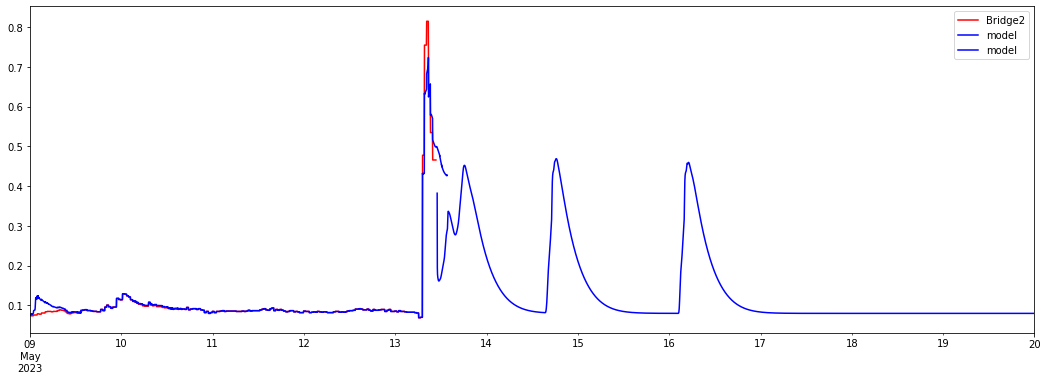

In [201]:
fig, ax = plt.subplots(figsize=(18, 6))
bridge_2.plot(ax=ax, c='r')
h_j_realtime[site_junction_name].plot(ax=ax, label='model', c='b')
h_j[site_junction_name].plot(ax=ax, label='model', c='b')

plt.xlim('20230509', '20230520')
plt.legend()

# J_WLR18_COMB_HEMP

In [202]:
#h_j.to_csv('h_j_kf.csv')

In [203]:
site_junction_name = 'J_WLR18_COMB_HEMP'
site_junction_index = 14

(1683590400.0, 1684540800.0)

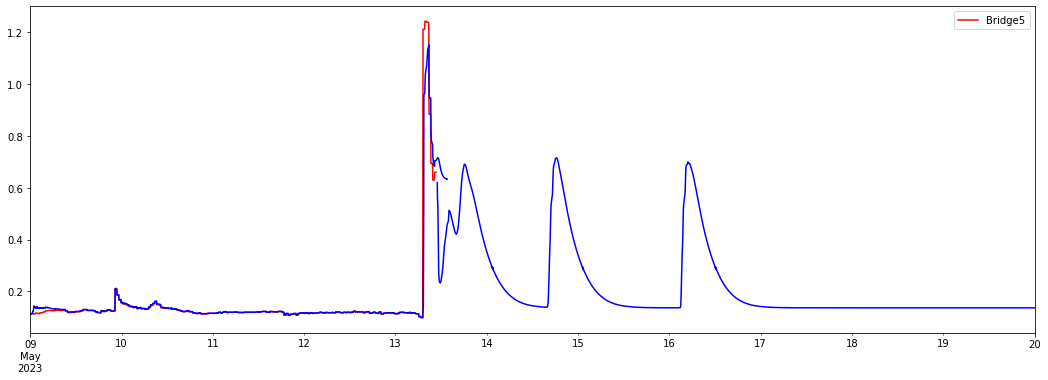

In [204]:
fig, ax = plt.subplots(figsize=(18, 6))
bridge_5.plot(ax=ax, c='r')
h_j_realtime[site_junction_name].plot(ax=ax, label='model', c='b')
h_j[site_junction_name].plot(ax=ax, label='model', c='b')
plt.xlim('20230509', '20230520')

# J_WLR19_23RD

In [205]:
site_junction_name ='J_WLR19_23RD' 
site_junction_index = 15

(1683590400.0, 1684540800.0)

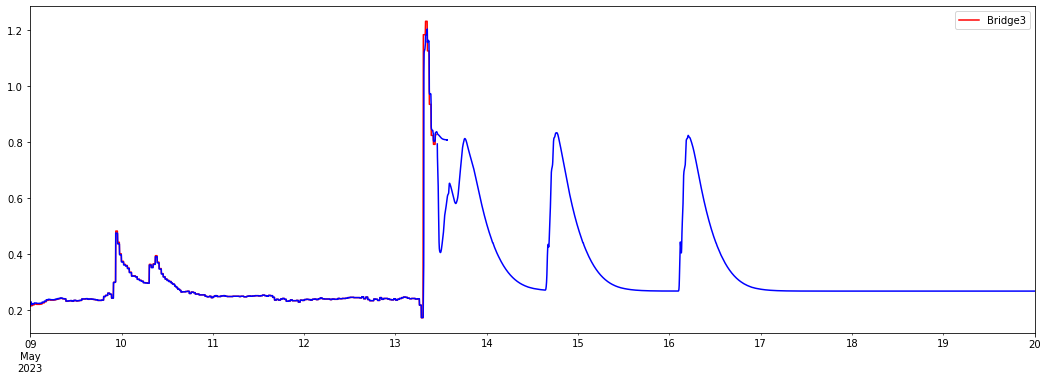

In [206]:
fig, ax = plt.subplots(figsize=(18, 6))
bridge_3.plot(ax=ax, c='r')
h_j_realtime[site_junction_name].plot(ax=ax, label='model', c='b')
h_j[site_junction_name].plot(ax=ax, label='model', c='b')
plt.xlim('20230509', '20230520')